#### Phân tích các than phiền của khách hàng  
Tiếp nối bài tìm hiểu "Brazilian_Ecommerce_EDA" trước, phần này sẽ tập trung vào việc tại sao số vote 1 point lại lên đến ~1.3%, cao hơn cả số vote 3 point và 2 point => Điều gì khiến khách hàng cảm thấy khó chịu và phải đánh giá tiêu cực như thế?  

In [2]:
import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import nltk

In [3]:
import os
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer 

In [4]:
filename = os.getcwd() + '\\olist_order_reviews_dataset.csv'
customer_dataset = pd.read_csv(filename)

customer_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [5]:
#Loai ra cac ban ghi co review_score = 1
veryBadFeedback = customer_dataset[customer_dataset['review_score'] == 1 & customer_dataset['review_comment_message'].notnull()]

#Text-preprocessing 1: lowercase/ remove number & punctuation
def textProcessing1 (str_):
    pattern = r'[\d+]'
    punchtua_table = str.maketrans('', '', string.punctuation)
    if (str_ != None):
        str_ = re.sub(pattern, '', str_) #Remove number
        str_ = str_.translate(punchtua_table)
        str_ = str_.lower()
    return str_

veryBadFeedback.loc[:, 'review_comment_message'] = veryBadFeedback['review_comment_message'].apply(textProcessing1)
veryBadFeedback.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37
29,2c5e27fc178bde7ac173c9c62c31b070,0ce9a24111d850192a933fcaab6fbad3,1,NaN,não gostei comprei gato por lebre,2017-12-13 00:00:00,2017-12-16 07:14:07
32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,NaN,sempre compro pela internet e a entrega ocorre...,2018-04-08 00:00:00,2018-04-09 12:22:39
39,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,NaN,nada de chegar o meu pedido,2017-04-21 00:00:00,2017-04-23 05:37:03
51,e233e51d11511bf30e568c76360ace52,548df2c6e5f089574614894bca78acf5,1,NaN,recebi somente controle midea split estilo\r\...,2018-01-28 00:00:00,2018-02-04 11:06:15


In [6]:
#Text-preprocessing 2: Remove stopwords & trim
#nltk.download('stopwords')
#nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def textProcessing2(sentences):
    if (sentences != None):
        stop_words = set(stopwords.words('portuguese'))
        #Split to remove stop words:
        check_token = word_tokenize(sentences)
        filter = [item for item in check_token if item not in stop_words]
    
    return ' '.join(filter)

veryBadFeedback.loc[:, 'review_comment_message'] = veryBadFeedback['review_comment_message'].apply(textProcessing2)
veryBadFeedback.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37
29,2c5e27fc178bde7ac173c9c62c31b070,0ce9a24111d850192a933fcaab6fbad3,1,NaN,gostei comprei gato lebre,2017-12-13 00:00:00,2017-12-16 07:14:07
32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,NaN,sempre compro internet entrega ocorre antes pr...,2018-04-08 00:00:00,2018-04-09 12:22:39
39,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,NaN,nada chegar pedido,2017-04-21 00:00:00,2017-04-23 05:37:03
51,e233e51d11511bf30e568c76360ace52,548df2c6e5f089574614894bca78acf5,1,NaN,recebi somente controle midea split estilo fal...,2018-01-28 00:00:00,2018-02-04 11:06:15


In [7]:
#Try to apply for title:
veryBadTitle = veryBadFeedback[veryBadFeedback['review_comment_title'].notnull()]
veryBadTitle.loc[:, 'review_comment_title'] = veryBadTitle['review_comment_title'].apply(textProcessing1)
veryBadTitle.loc[:, 'review_comment_title'] = veryBadTitle['review_comment_title'].apply(textProcessing2)

veryBadTitle.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,chegou produto,péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37
167,5f938e5f5f2e9a75710b54feeb9ea610,d9ff0185a300435402f043124f530274,1,médio,peça serviu,2018-05-11 00:00:00,2018-05-14 14:08:04
190,c40a6b6e0181e5ec0d12cbc2e12c49d3,f3468d6a2c7586711e9952242898aad4,1,falta produto quebra,faltou produto recebi veio quebrado,2018-05-23 00:00:00,2018-05-23 22:23:00
197,06f47dacd0575e592bf6a17e922ce6cd,82348f1b5f24ac795fa9320e02c49553,1,recebi ainda,aqui descrevendo entregue ate agora recebi,2018-06-28 00:00:00,2018-06-29 16:34:46
276,f7eb8792e67d53e01a224bfa9b6802b2,a0f2f8b0523207a13f02225bc812ed23,1,horrível,cancelaram compra dia antes entrega liguei lan...,2018-08-05 00:00:00,2018-08-05 09:27:55


#### Ta chia ra 2 hướng phân tích:  
1. Phân tích nội dung comment: Dựa vào các comment đã có, phân loại ra thông tin nào được nhắc đến nhiều nhất => tra vết lại order và sản phẩm có trong hóa đơn đó  
2. Phân tích toàn thể các title comment: Có giá trị tham khảo, để xác định xem hầu hết mọi người nhắc đến điều gì  

Có thể kết hợp với ngày giờ thực nhận hàng và ngày đăng comment để xác định xem vấn đề của các rate 1 points là do đâu

In [8]:
## Phan tich noi dung comment
#1. Lay tan suat cac tu co trong comment
freqTable = dict()
def getFreqWord(sentence):
    if (sentence != None):
        list_token = word_tokenize(sentence)
        for item in list_token:
            if (item in freqTable):
                freqTable[item] += 1
            else:
                freqTable[item] = 1

#2. Lay diem cac cau comment dua tren diem tan suat cac tu chua trong no
sentencesValue = dict()
def getScoreSentence(sentence):
    for key, value in freqTable.items():
        if (key in sentence):
            if (sentence in sentencesValue):
                sentencesValue[sentence] += value
            else:
                sentencesValue[sentence] = value

summary = ""
#3. Tra ve summary comment chung:
def getTheFinalSummary(sentence):
    global summary
    if (sentence!=None or sentence != ''):
        #Tinh diem danh gia chung
        sumValue = 0
        for item in sentencesValue:
            sumValue += sentencesValue[item]
        ranking_rate = int(sumValue/len(sentencesValue))
        #Danh gia
        if (sentencesValue[sentence] > 1.2*ranking_rate):
            summary+= sentence + '.\n'
            return 'X'
        else: return None

In [9]:
#Apply:
veryBadFeedback['review_comment_message'].apply(getFreqWord)
veryBadFeedback['review_comment_message'].apply(getScoreSentence)
#veryBadFeedback.loc[:, 'marked'] = veryBadFeedback['review_comment_message'].apply(getTheFinalSummary)

print(len(sentencesValue))

8082


In [10]:
veryBadFeedback = veryBadFeedback[veryBadFeedback['review_comment_message'] != '']
veryBadFeedback = veryBadFeedback.assign(marked = veryBadFeedback['review_comment_message'].apply(getTheFinalSummary))

print(summary)

sempre compro internet entrega ocorre antes prazo combinado acredito prazo máximo stark prazo máximo esgotou ainda recebi produto.
produto chegou prazo estipulado causou transtorno pq programei viagem férias filho baseado prazo moro bahia cuiabá sozinho agora casa vazia.
recebi produto consta sistema recebi além pagar caro frete.
comprei produto dia fevereiro hoje dia marco entregue residência sei correios desse brasil péssimo própria loja demorou postar.
fiz compra faz dias recebi ainda produto precisa melhorar entregas.
faltou produto recebi veio quebrado.
comprei dois produtos recebi somente mandei dois emails loja nenhum retorno insatisfeita.
agora recebi produto.
recebi bem rápido porém veio outro produto pedi modelo veio diferente cor veio capinha zíper enfim recomendo.
desordenado comprei três produtos veio dia sertões veio separado data separada.
tentando cancelar produto desde antes emissão nota fiscal avisada correio nenhuma resposta cancelamento nao consigo devolver.
boa noi

In [11]:
#Loc ra cac ban ghi duoc danh dau co xuat hien trong phan summary cuoi
toClassificateFb = veryBadFeedback[veryBadFeedback['marked'] == 'X']
toClassificateFb.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,marked
32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,NaN,sempre compro internet entrega ocorre antes pr...,2018-04-08 00:00:00,2018-04-09 12:22:39,X
68,6d06808638ec0701bccd70bc8d462c28,97d2f8fe76f2f253b8291e17b5383884,1,NaN,produto chegou prazo estipulado causou transto...,2016-12-09 00:00:00,2016-12-19 14:10:43,X
149,ef8ae544c432bb1053ba5990bd0d6227,e18ebd6286697a3f0f6fe267d8286cb2,1,NaN,recebi produto consta sistema recebi além paga...,2018-01-12 00:00:00,2018-01-13 00:28:49,X
168,d7ea05bb4f9c77d606fd90b1a27e317d,bb5b0d8f3e9c964760c674f2aa2ae0cf,1,NaN,comprei produto dia fevereiro hoje dia marco e...,2018-03-29 00:00:00,2018-03-29 23:13:58,X
169,185cb85ede91009d7a8e685687c037ee,2e5dc86c8c4aa663549caf5e31de840d,1,NaN,fiz compra faz dias recebi ainda produto preci...,2017-04-06 00:00:00,2017-04-09 18:25:12,X


Do kết quả summary các bình luận cuối cùng có nhiều chủ đề khác nhau =>  
Ta **áp dụng kỹ thuật Clustering Document** để phân loại định danh các vấn đề cho 1 nhóm cụ thể các feedback, từ đó truy vết lại các sản phẩm trong order, bản thân order và thời gian nhận hàng chuyển hàng của order đó

Text(0, 0.5, 'Inertia')

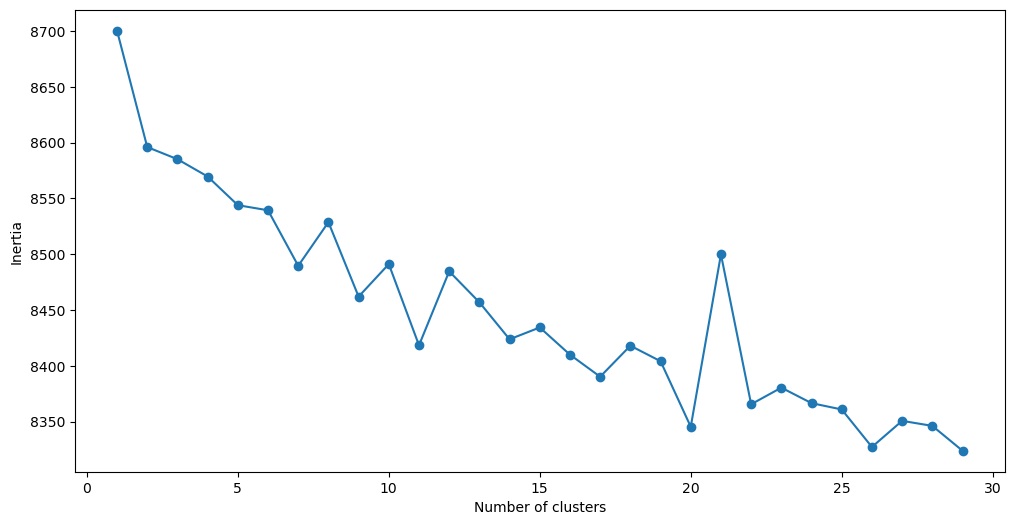

In [12]:
sentence = veryBadFeedback['review_comment_message']
# create vectorizer 
vectorizer = TfidfVectorizer(use_idf=True, max_df=0.5, min_df=1, ngram_range=(1,5)) 

# vectorizer the text documents 
vectorized_documents = vectorizer.fit_transform(sentence) 

# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,30):
    kmeans = KMeans(n_clusters = cluster, init='k-means++', n_init='auto')
    kmeans.fit(vectorized_documents)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,30), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [13]:
#Init_cluster = 28

n_cluster = 28
k_means_model = KMeans(n_clusters=n_cluster, n_init='auto', max_iter=500, random_state=40)
k_means_model.fit(vectorized_documents)

#result:
result =pd.DataFrame()
result['order_id'] = veryBadFeedback['order_id']
result['review_comment'] = veryBadFeedback['review_comment_message']
result['label'] = k_means_model.labels_

result['label'].value_counts()


label
9     4836
15     851
11     435
20     392
2      305
25     288
1      166
19     127
8      127
13     120
16     110
26     107
23     103
5       94
4       90
6       86
0       67
12      61
27      59
18      55
14      53
17      48
7       40
3       39
10      32
21      18
22      15
24      10
Name: count, dtype: int64

In [15]:
#Check thu nhom 14:
group14 = result[result['label'] == 14].sample(n=10, random_state=1)
checkList = group14['review_comment'].to_list()
order_idList = group14['order_id'].to_list()

for item in checkList:
    print(item, end='.\n')

produto chegou hoje.
chegou.
produto chegou hoje.
chegou.
chegou.
chegou.
produto chegou ainda.
chegou ainda.
produto chegou ainda.
produto nao chegou.


In [16]:
orinList = customer_dataset[customer_dataset['order_id'].isin(order_idList)]['review_comment_message'].to_list()

for item in orinList:
    print(item, end='\n')

Não chegou
O MEU PRODUTO NAO CHEGOU
O produto não chegou até hoje!
Não chegou 
não chegou
Produto não chegou ainda 
não chegou ainda
Produto não chegou ainda 
Não chegou.
o PRODUTO NÃO CHEGOU ATÉ HOJE.


In [17]:
# Tu moi nhom, lay ra cac keyword

#1. create a list of tfidf_vectors to store the dictionaries of all documents.
dict_of_tokens={i[1]:i[0] for i in vectorizer.vocabulary_.items()}

tfidf_vectors = []  # all deoc vectors by tfidf
for row in vectorized_documents:
  tfidf_vectors.append({dict_of_tokens[column]:value for (column,value) in zip(row.indices,row.data)})

#2. Sorting keyphrases by TFIDF weights
doc_sorted_tfidfs =[]  # list of doc features each with tfidf weight
#sort each dict of a document
for dn in tfidf_vectors:
  newD = sorted(dn.items(), key=lambda x: x[1], reverse=True)
  newD = dict(newD)
  doc_sorted_tfidfs.append(newD)

#3. get a list of keywords without their weights.
tfidf_kw = [] # get the keyphrases as a list of names without tfidf values
for doc_tfidf in doc_sorted_tfidfs:
  ll = list(doc_tfidf.keys())
  tfidf_kw.append(ll)

In [19]:
# Output into csv file
filename_out = os.getcwd() + '\\MainContext.csv'

with open(filename_out, 'w') as csvfile:
    for item in range(0, 28):
        csvfile.write(f'{item} : ')
        for line in tfidf_kw[item][0:5]:
            csvfile.write(line + ', ')
        csvfile.write('.\n')

In [20]:
#For some group not yet know the deep meaning, take those out and see random 5 comment:

def getDetailComment(num_):
    # retrive the review_id from the marked table:
    order_list = result[result['label'] == num_]['order_id'].to_list()
    # Take random 5 comment:
    customer_fb = customer_dataset[customer_dataset['order_id']
                                   .isin(order_list)]['review_comment_message'].sample(n=10, random_state=40).to_list()
    #print it
    for item in customer_fb:
        print(item, end='\n')

In [23]:
getDetailComment(23)

solicito a devolucao do produto
A entrega foi super rápida, está de parabéns. A bolsa é bonita, mas eu pensava que o material era melhor.
comprei um lençol de solteiro e a loja me enviou um lençol de casal. Solicito a troca
POis o material parece não ter muita durabilidade, e cor é mais escura do que a imagem de ilustração!
Apesar de fazer a mesma funções, trocaram os adaptadores e esse que recebi aparentemente parece ser inferior ao que comprei, tanto em qualidade do material como o valor 5x mais barato
Não posso avaliar sem ter recebido o material, até agora minha avaliação é extremamente negativa.
Não gostei do material do produto,o acabamento é ruim nota-se imperfeições!!!!
O material da mochila ficou a desejar.
RECEBI O PRODUTO ERRADO, SOLICITO A TROCA
Solicito entrega da mercadoria


In [24]:
#Read transalte file and get the trans dict
trans_dict = dict()

trans_file = os.getcwd() + '\\MainContextTrans.txt'

with open(trans_file, 'rt') as reader:
    for lines in reader:
        word_split = lines.split(':')
        word_index = word_split[0]
        word_cate = word_split[1]
        trans_dict[word_index] = word_cate

print(len(trans_dict))

28


In [25]:
#Map to the label
result['label'] = result['label'].apply(lambda x: str(x))

result = result.assign(category = result['label'].map(trans_dict))
result['category'] = result['category'].str.replace('\n', '')

result.head()

,order_id,review_comment,label,category
19,583174fbe37d3d5f0d6661be3aad1786,péssimo,21,Product mismatch and poor quality
29,0ce9a24111d850192a933fcaab6fbad3,gostei comprei gato lebre,9,Product mismatch
32,68e55ca79d04a79f20d4bfc0146f4b66,sempre compro internet entrega ocorre antes pr...,9,Product mismatch
39,3c314f50bc654f3c4e317b055681dff9,nada chegar pedido,25,Late delivery
51,548df2c6e5f089574614894bca78acf5,recebi somente controle midea split estilo fal...,9,Product mismatch


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


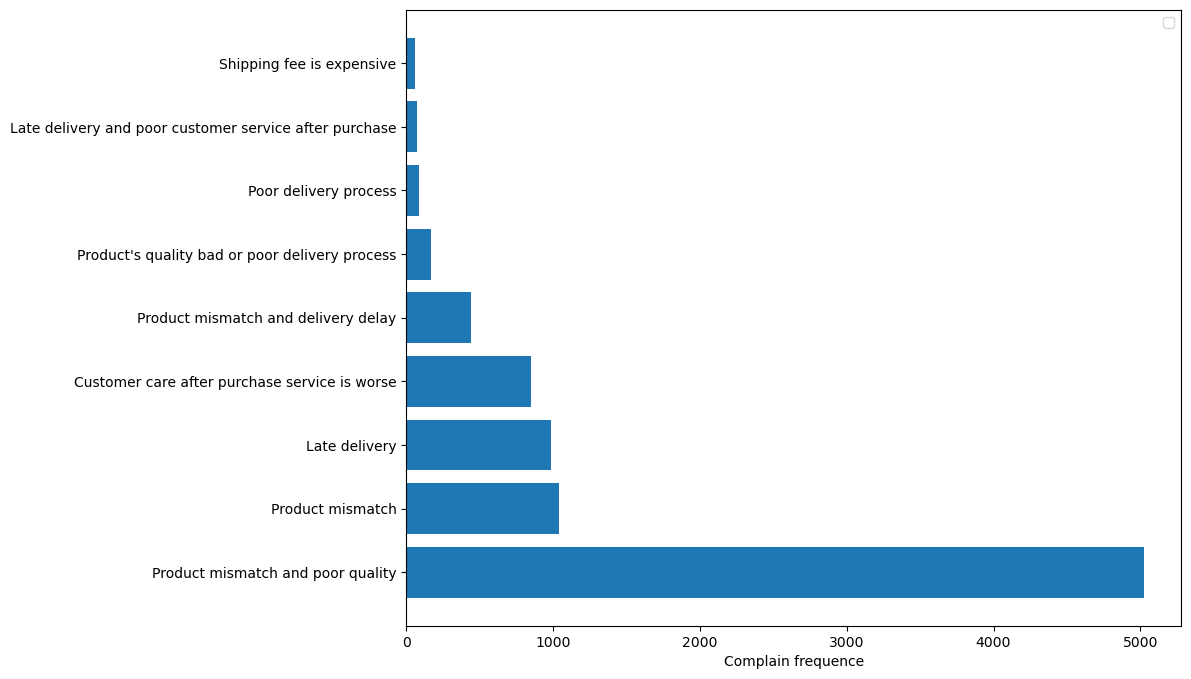

In [26]:
# Ve do thi bar de xem tuong quan cac nhom khieu nai

fig, ax = plt.subplots(figsize=(10, 8))

label = result['category'].unique().tolist()

y_pos = np.arange(len(label))
freq = result['category'].value_counts().to_list()
ax.barh(y_pos, freq)
ax.set_yticks(y_pos, labels=label)
ax.set_xlabel('Complain frequence')

plt.legend()
plt.show()

Qua phân tích feedback khách hàng ta thấy đa phần các đánh giá 1 sao đều đến từ một vài nhóm lý do chính:  
- **Giao hàng không đúng với thông tin trên trang web đưa và sản phẩm khi đến tay khách hàng thì không tốt**  
- **Giao hàng muộn**  
- **Quá trình vận chuyển có vấn đề gây hỏng sản phẩm hoặc bản thân sản phẩm là không tốt**  

Thậm chí có 1 vài comment chỉ thẳng mặt tên các sale store trên nền tảng e-commerce này, ví dụ như của Lamiston chất lượng hàng hóa và dịch vụ hậu mãi có vấn đề  
=> Điều đó cho thấy nền tảng này nên xem lại các sales store và rà soát lại chất lượng sản phẩm cũng như việc giao hàng trễ, bởi như hiện tại thì số đánh giá 1 point trên 1% (cao hơn cả số đánh giá 3 point), và thậm chí rất nhiều comment cho thấy sẽ từ bỏ nền tảng này